In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from behavior import get_extent
from spatial import gaussian_kernel_2D, get_field_patches

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def density_map(fit, extent, sigma=0.4, bin_count=100):
    pos_range = np.array([[extent[0], extent[1]], [extent[2], extent[3]]])

    d_map, xs_edges, ys_edges = np.histogram2d(fit[:, 0], fit[:, 1], bins=[bin_count, bin_count], range=pos_range)

    kernel = gaussian_kernel_2D(sigma)
    return signal.convolve2d(d_map, kernel, mode='same')

In [13]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
#source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

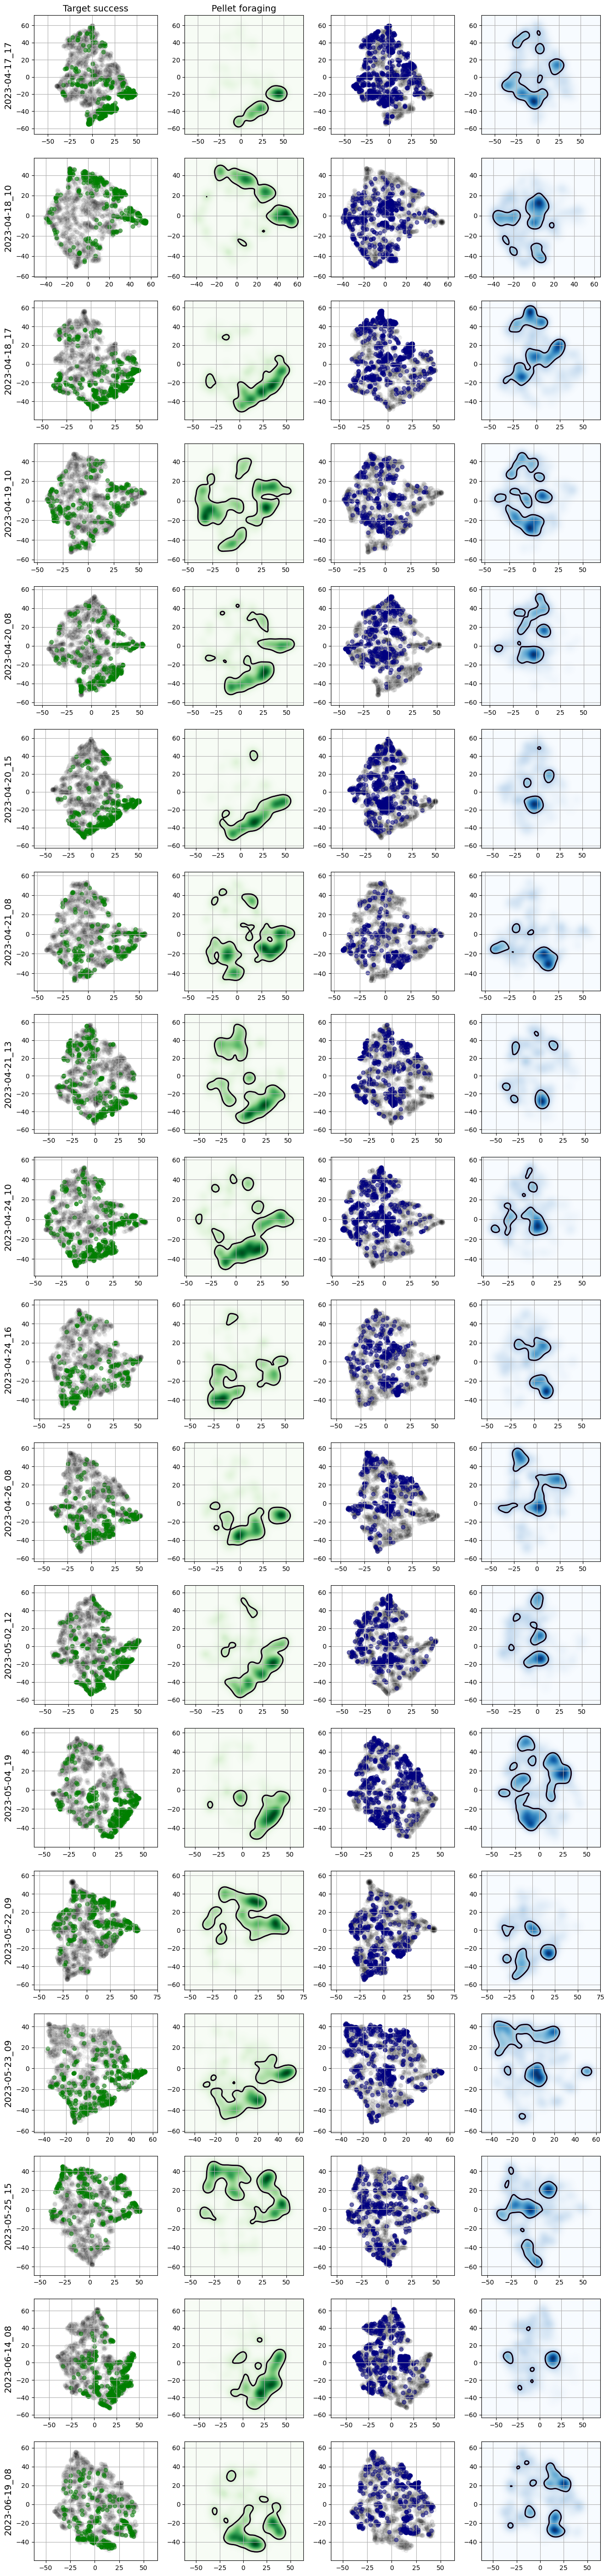

In [15]:
fit_type = 'tSNE'
fit_parm = 70
#fit_type = 'UMAP'
#fit_parm = 0.5

rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
        
    idxs_srm_succ   = []
    idxs_srm_pellet = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        idxs_srm_pellet += list(np.where((idxs_srm_tl > tl_r + 1*100) & (idxs_srm_tl < tl_r + 8*100))[0])
        
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_sil = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]

    sigma = 0.3
    margin = 10
    extent = get_extent(fit, margin=margin)
        
    ax = axes[i][0]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.02, color='black')
    ax.scatter(fit[idxs_srm_succ][:, 0], fit[idxs_srm_succ][:, 1], alpha=0.5, color='green')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_ylabel(session[-19:-6], fontsize=14)
    ax.grid()

    ax = axes[i][1]
    d_succ_map = density_map(fit[idxs_srm_succ], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.2*d_succ_map.max(), d_succ_map.max(), 2)
    CS_succ = ax.contour(d_succ_map.T, levels, origin='lower', linewidths=2, extent=extent)
    ax.imshow(d_succ_map.T, cmap='Greens', origin='lower', extent=extent)
    for path in CS_succ.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()

    ax = axes[i][2]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.02, color='black')
    ax.scatter(fit[idxs_srm_pellet][:, 0], fit[idxs_srm_pellet][:, 1], alpha=0.5, color='navy')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()

    ax = axes[i][3]
    d_pellet_map = density_map(fit[idxs_srm_pellet], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.3*d_pellet_map.max(), d_pellet_map.max(), 2)
    CS_pellet = ax.contour(d_pellet_map.T, levels, origin='lower', linewidths=2, extent=extent)
    ax.imshow(d_pellet_map.T, cmap='Blues', origin='lower', extent=extent)
    for path in CS_pellet.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()

    if i == 0:
        axes[i][0].set_title('Target success', fontsize=14)
        axes[i][1].set_title('Pellet foraging', fontsize=14)
